# Número Óptimo de Clusters

Datos utilizados: https://www.kaggle.com/datasets/arushchillar/disneyland-reviews

Notebook original: https://towardsdatascience.com/hands-on-topic-modeling-with-python-1e3466d406d7

In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("fivethirtyeight")
pd.set_option('display.max_colwidth', 80)
import matplotlib.patheffects as path_effects
import nltk
import numpy as np
import seaborn as sns
import gensim
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Data

In [5]:
import json
from google.colab import drive

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/kaggle.json", 'r') as f:
    api_token= json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d arushchillar/disneyland-reviews

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Mounted at /content/drive
  0% 0.00/11.1M [00:00<?, ?B/s]
100% 11.1M/11.1M [00:00<00:00, 119MB/s]


In [20]:
import zipfile
import os

os.listdir()

for file in os.listdir():
    if file.endswith('.zip'):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
     

reviews = pd.read_csv('/content/DisneylandReviews.csv',encoding='latin-1')

In [21]:
reviews.head(5)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong ...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,"Its been a while since d last time we visit HK Disneyland .. Yet, this time ...",Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid when I was visiting the park o...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortunately there is quite a bit of...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1 hour from Kowlon, my kids lik...",Disneyland_HongKong


In [22]:
reviews.Review_Text[1]

"Its been a while since d last time we visit HK Disneyland .. Yet, this time we only stay in Tomorrowland .. AKA Marvel land!Now they have Iron Man Experience n d Newly open Ant Man n d Wasp!!Ironman .. Great feature n so Exciting, especially d whole scenery of HK (HK central area to Kowloon)!Antman .. Changed by previous Buzz lightyear! More or less d same, but I'm expecting to have something most!!However, my boys like it!!Space Mountain .. Turns into Star Wars!! This 1 is Great!!!For cast members (staffs) .. Felt bit MINUS point from before!!! Just dun feel like its a Disney brand!! Seems more local like Ocean Park or even worst!!They got no SMILING face, but just wanna u to enter n attraction n leave!!Hello this is supposed to be Happiest Place on Earth brand!! But, just really Dont feel it!!Bakery in Main Street now have more attractive delicacies n Disney theme sweets .. These are Good Points!!Last, they also have Starbucks now inside the theme park!!"

In [24]:
reviews.Branch.unique()

array(['Disneyland_HongKong', 'Disneyland_California', 'Disneyland_Paris'],
      dtype=object)

In [25]:
reviews = reviews[["Review_Text", "Rating"]]
reviews = reviews.drop_duplicates(subset='Review_Text')

<Axes: xlabel='Rating', ylabel='count'>

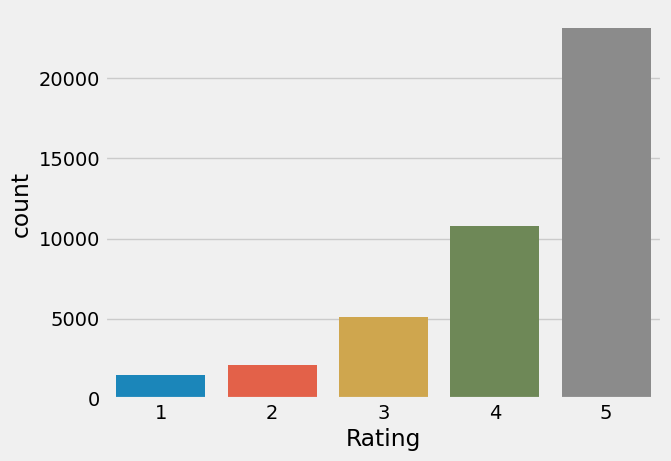

In [26]:
# Create a bar plot with value counts

sns.countplot(x='Rating', data=reviews)

# 2.  Data Cleaning and Preprocessing

In [27]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [28]:
def text_preprocessing(text):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Expand contractions
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text) 

    # Tokenize each word
    text = nltk.WordPunctTokenizer().tokenize(text)

    # Lemmatize each word
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text if len(token)>1]

    return text

def to_string(text):
    # Convert list to string
    text = ' '.join(map(str, text))

    return text

In [29]:
reviews['Review_Clean_List'] = list(map(text_preprocessing, reviews.Review_Text))

In [30]:
reviews['Review_Clean'] = list(map(to_string, reviews['Review_Clean_List']))

In [31]:
pd.set_option('display.max_colwidth', 15000)
reviews.sample()

,Review_Text,Rating,Review_Clean_List,Review_Clean
42637,"I visited in Sept 2004, staying 3 nights at the Disneyland Hotel. I had read so many forums on the internet about the accommodation that I decided to spend the extra & stay there & I don't regret it! It was luxury and the location was brilliant with a toddler who needed her afternoon nap! The characters were around at breakfast & the breakfast itself was great plenty of food & selection. No queues in the park, which was great. OK, things were expensive, but I expected that. In the Disney Village, the best restaurant in our experience was the Rainforest Cafe. Dinner was no more expensive than in Ireland, service & food great. We also tried the Steakhouse, but had a bad meal & bad service. We had a brilliant holiday.",5,"[visit, in, sept, 2004, stay, nights, at, the, disneyland, hotel, have, read, so, many, forums, on, the, internet, about, the, accommodation, that, decide, to, spend, the, extra, stay, there, do, not, regret, it, it, be, luxury, and, the, location, be, brilliant, with, toddler, who, need, her, afternoon, nap, the, character, be, around, at, breakfast, the, breakfast, itself, be, great, plenty, of, food, selection, no, queue, in, the, park, which, be, great, ok, things, be, expensive, but, expect, that, in, the, disney, village, the, best, restaurant, in, our, experience, be, the, rainforest, cafe, dinner, be, no, more, expensive, than, in, ireland, ...]",visit in sept 2004 stay nights at the disneyland hotel have read so many forums on the internet about the accommodation that decide to spend the extra stay there do not regret it it be luxury and the location be brilliant with toddler who need her afternoon nap the character be around at breakfast the breakfast itself be great plenty of food selection no queue in the park which be great ok things be expensive but expect that in the disney village the best restaurant in our experience be the rainforest cafe dinner be no more expensive than in ireland service food great we also try the steakhouse but have bad meal bad service we have brilliant holiday


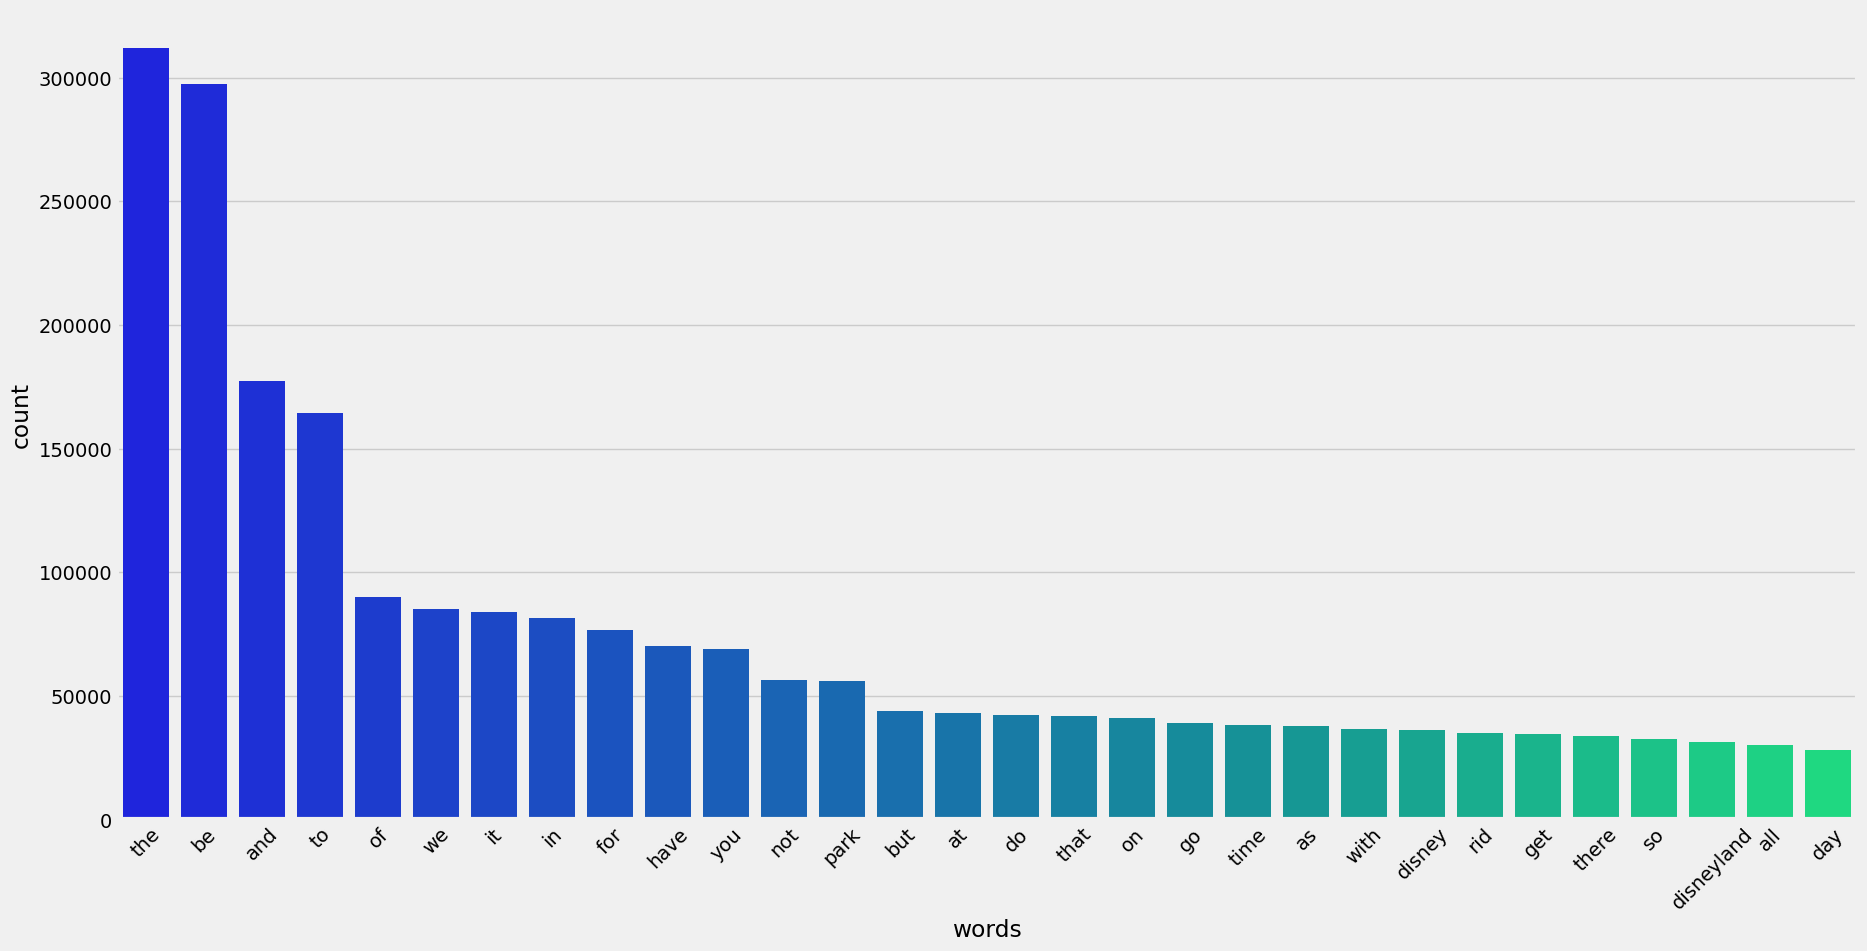

In [32]:
# Join  text together
review_words = ','.join(list(reviews['Review_Clean'].values))

# Count each word
Counter = Counter(review_words.split())
most_frequent = Counter.most_common(30)

fig = plt.figure(1, figsize = (20,10))
_ = pd.DataFrame(most_frequent, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')
plt.xticks(rotation=45);

In [33]:
stopwords_list = stopwords.words('english')
stopwords_list.extend(['park', 'disney', 'disneyland'])

In [34]:
reviews['Review_Clean_List'] = [[word for word in line if word not in stopwords_list] for line in reviews['Review_Clean_List']]

In [35]:
reviews['Review_Clean'] = list(map(to_string, reviews['Review_Clean_List']))

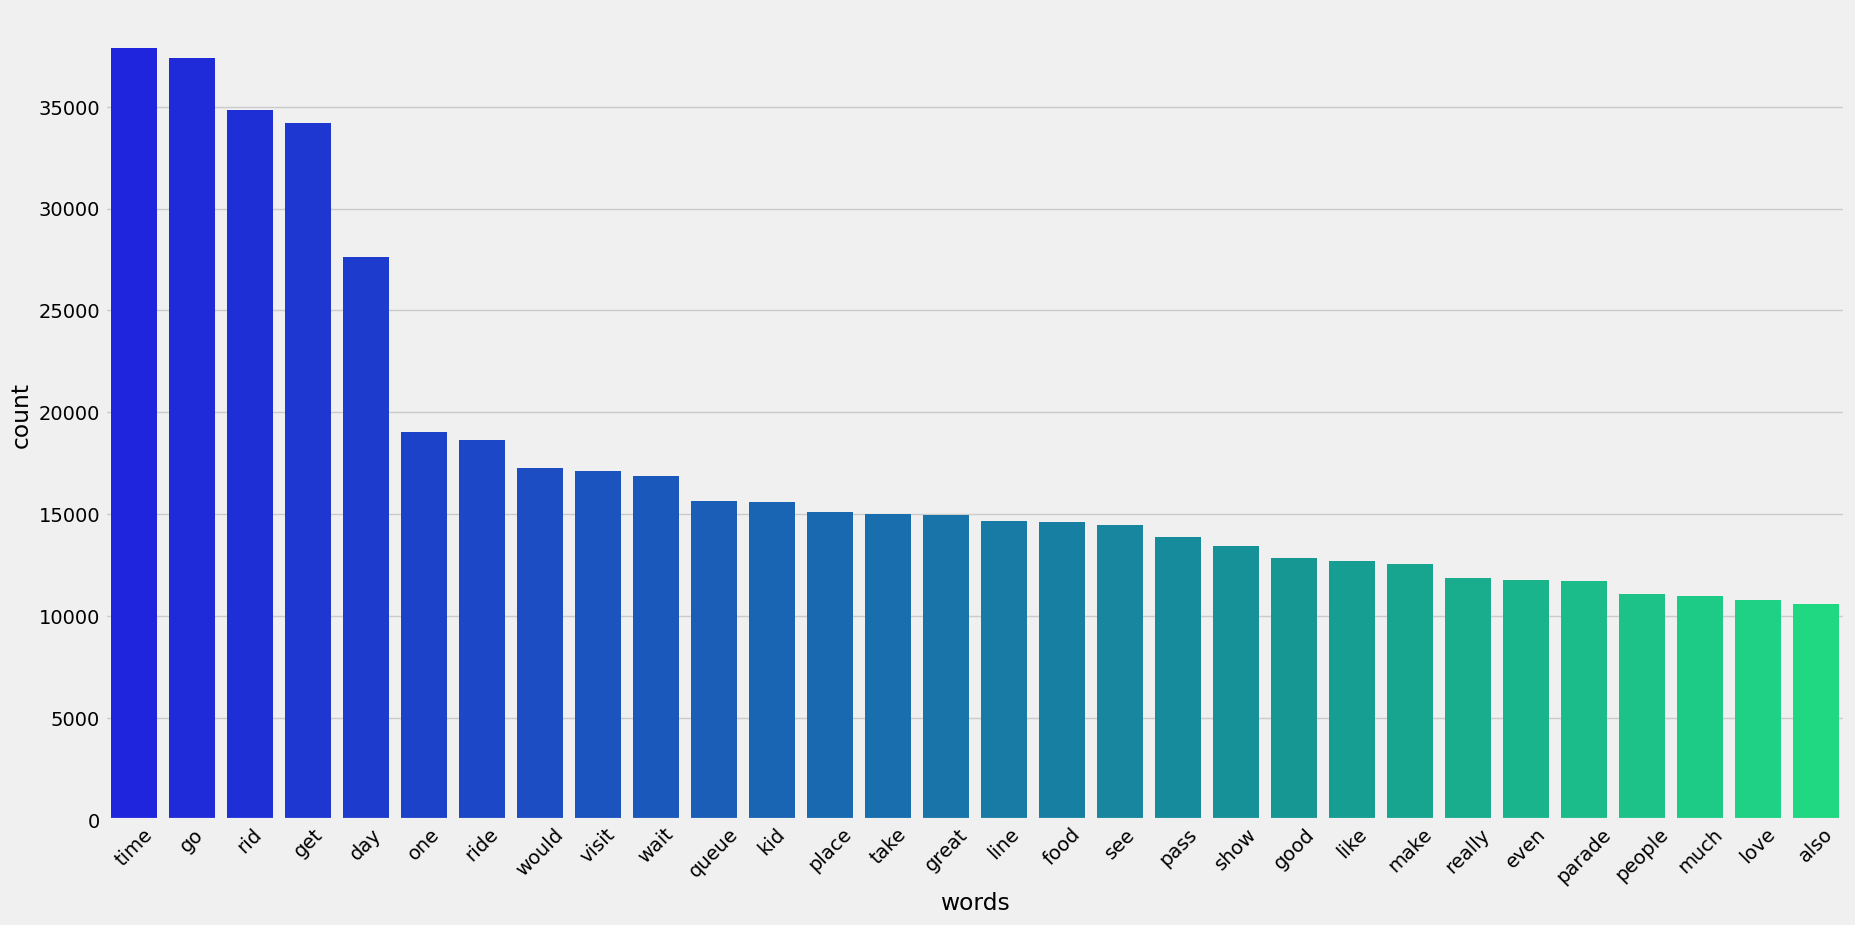

In [36]:
from collections import Counter

# Join  text together
review_words = ','.join(list(reviews['Review_Clean'].values))

# Count each word
Counter = Counter(review_words.split())
most_frequent = Counter.most_common(30)

# Bar plot of frequent words
fig = plt.figure(1, figsize = (20,10))
_ = pd.DataFrame(most_frequent, columns=("words","count"))
sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')
plt.xticks(rotation=45);

# 3. Bag-of-Words

In [37]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(reviews['Review_Clean_List'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in reviews['Review_Clean_List']]

# 4. Número óptimo de clusters

CV Coherence Score

In [47]:
from gensim.models import CoherenceModel
# Compute Coherence Score
number_of_topics = []
coherence_score = []
n_topics=[5,8,12,20]
for i in n_topics:
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews['Review_Clean_List'], dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda)

In [48]:
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics, 'coherence_score':coherence_score})

In [49]:
topic_coherence

,number_of_topics,coherence_score
0,5,0.363826
1,8,0.386376
2,12,0.365508
3,20,0.359135


<Axes: xlabel='number_of_topics', ylabel='coherence_score'>

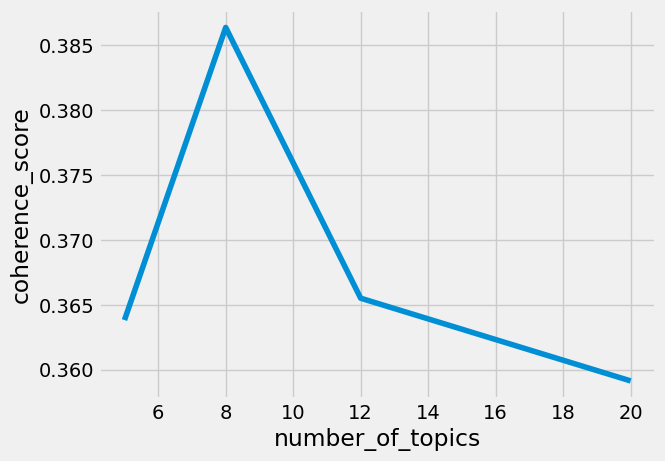

In [50]:
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score').set(
    title="CV Coherence Score")

UCI Coherence Score

In [56]:
number_of_topics = []
coherence_score = []
n_topics=[5,8,12,20]
for i in n_topics:
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews['Review_Clean_List'], dictionary=id2word, coherence='c_uci')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda);

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics, 'coherence_score':coherence_score})

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
topic_coherence

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,number_of_topics,coherence_score
0,5,0.007579
1,8,0.051893
2,12,-0.480336
3,20,-0.107958


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='number_of_topics', ylabel='coherence_score'>

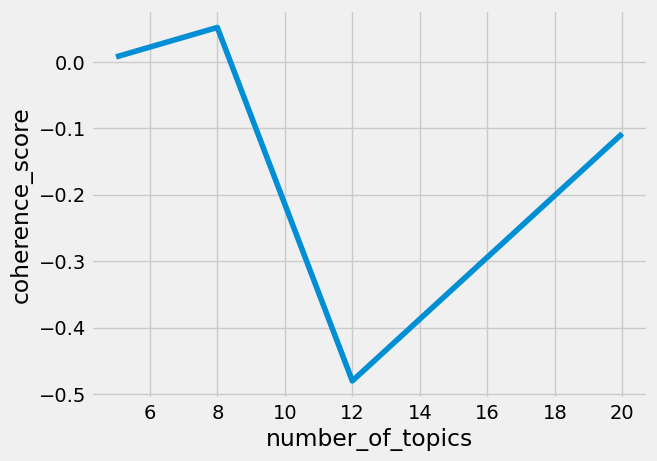

In [59]:
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score').set(
    title="UCI Coherence Score")

UMass Coherence Score

In [66]:
number_of_topics = []
coherence_score = []
n_topics=[2,5,8,12]
for i in n_topics:
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews['Review_Clean_List'], dictionary=id2word, coherence='u_mass')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda);

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics, 'coherence_score':coherence_score})

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
topic_coherence

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,number_of_topics,coherence_score
0,2,-1.199382
1,5,-1.353414
2,8,-1.493500
3,12,-1.611359


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Text(0.5, 1.0, 'UMass Coherence Score')]

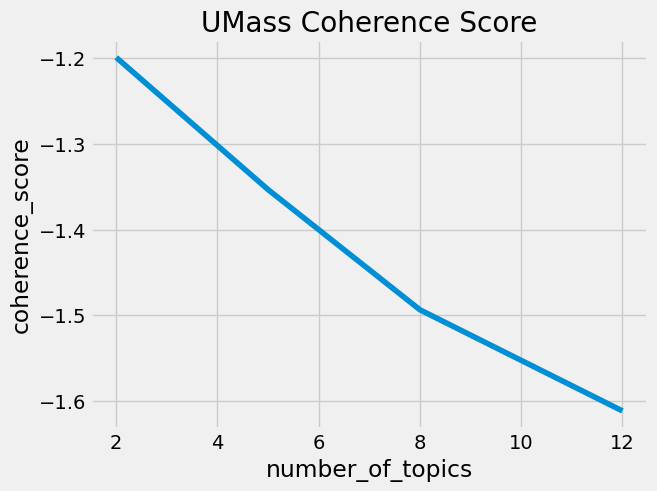

In [69]:
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score').set(
    title="UMass Coherence Score")

Sklearn

In [77]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', random_state=0, verbose=0)

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(ngram_range=(1,1))
bow = vect.fit_transform(reviews['Review_Clean'])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.model_selection import GridSearchCV
search_params = {'n_components': [5,8,12]}

model = LatentDirichletAllocation(max_iter=50, learning_method='online', learning_offset=50.,random_state=0)

gridsearch = GridSearchCV(model,
                          param_grid=search_params,
                          n_jobs=-1,
                          verbose=1, 
                          cv=2)
gridsearch.fit(bow)

## Save the best model
best_lda = gridsearch.best_estimator_

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fitting 2 folds for each of 3 candidates, totalling 6 fits


In [ ]:
# LDA en Sklearn tiene un resultado de score correspondiente al log-likelihood. En base a ese criterio se identifica el número óptimo de clusters. 
# Una versión acá: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#13compareldamodelperformancescores

cv_results_df = pd.DataFrame(gridsearch.cv_results_)

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.pointplot(x="param_n_components",
              y="mean_test_score",
              data=cv_results_df).set(
    title="Sklearn log-likelihood")

# 5. Topic Modeling with LDA

In [51]:
n_topics = 8

# Puedo usar el LDA de sklearn
#from sklearn.decomposition import LatentDirichletAllocation
# lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', random_state=0, verbose=0)
# lda_topic_matrix = lda_model.fit_transform(id2word)

# O el de gensim
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True);

In [52]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))
    print("\n")

Topic: 0 Word: 0.044*"price" + 0.040*"studios" + 0.039*"drink" + 0.037*"pay" + 0.029*"cost" + 0.028*"etc" + 0.028*"food" + 0.025*"bus" + 0.023*"meal" + 0.020*"disappoint"


Topic: 1 Word: 0.031*"food" + 0.027*"people" + 0.026*"queue" + 0.023*"would" + 0.023*"take" + 0.021*"expensive" + 0.018*"fast" + 0.015*"go" + 0.015*"good" + 0.013*"way"


Topic: 2 Word: 0.000*"cloths" + 0.000*"mexico" + 0.000*"sufficiently" + 0.000*"disneyparis" + 0.000*"ahit" + 0.000*"1996" + 0.000*"fa" + 0.000*"disadvantage" + 0.000*"villiage" + 0.000*"michelle"


Topic: 3 Word: 0.039*"go" + 0.028*"time" + 0.020*"paris" + 0.016*"great" + 0.015*"kid" + 0.015*"rid" + 0.014*"day" + 0.013*"visit" + 0.013*"really" + 0.012*"much"


Topic: 4 Word: 0.024*"ride" + 0.019*"character" + 0.018*"get" + 0.015*"could" + 0.015*"think" + 0.015*"eat" + 0.014*"want" + 0.014*"also" + 0.013*"mountain" + 0.012*"little"


Topic: 5 Word: 0.085*"hotel" + 0.040*"pass" + 0.039*"ticket" + 0.028*"book" + 0.026*"breakfast" + 0.024*"buy" + 0.023

# 6. Visualising with pyLDAvis

In [54]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 30.0 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


In [55]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.233944  0.031083       1        1  38.778796
4     -0.128864  0.062824       2        1  20.420106
1     -0.210485 -0.077693       3        1  15.834698
6     -0.189077 -0.015737       4        1  10.056574
5      0.139490  0.209891       5        1   6.323559
0      0.202413 -0.382239       6        1   4.695980
7      0.257770  0.170060       7        1   3.687737
2      0.162698  0.001812       8        1   0.202551, topic_info=             Term          Freq         Total Category  logprob  loglift
56            get  37633.000000  37633.000000  Default  30.0000  30.0000
615         hotel  14181.000000  14181.000000  Default  29.0000  29.0000
17          queue  23019.000000  23019.000000  Default  28.0000  28.0000
92          staff   8862.000000   8862.000000  Default  27.0000  27.0000
128          food  16324.000000  16324.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
35883   revisting      0.149847      0.894367   Topic8 -10.4850   4.4154
20772     allways      0.149788      1.630046   Topic8 -10.4854   3.8148
19623        alex      0.149748      0.692415   Topic8 -10.4857   4.6707
2926   restuarant      0.149722      1.072855   Topic8 -10.4858   4.2326
35856       whice      0.149700      0.908412   Topic8 -10.4860   4.3989

[420 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
925       4  0.999791     00
108       4  0.999965     10
382       4  0.999534     11
460       4  0.999949     20
393       4  0.999916     30
...     ...       ...    ...
27        1  0.999870  worth
154       2  0.304621  would
154       3  0.493271  would
154       4  0.202103  would
511       1  0.999929   year

[348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 7, 6, 1, 8, 3])